# Problem Board Coloration

The (chess)board coloration problem is to color all squares of a board composed of $n$ rows and $m$ columns such that the four corners of any rectangle in the board must not be assigned the same color.
Importantly, we want to minimize the number of used colors.

Coloring boards. <small>Image from [Pixabay](https://pixabay.com/fr/photos/jeu-d-%c3%a9checs-jeu-de-plateau-3467512/)</small>
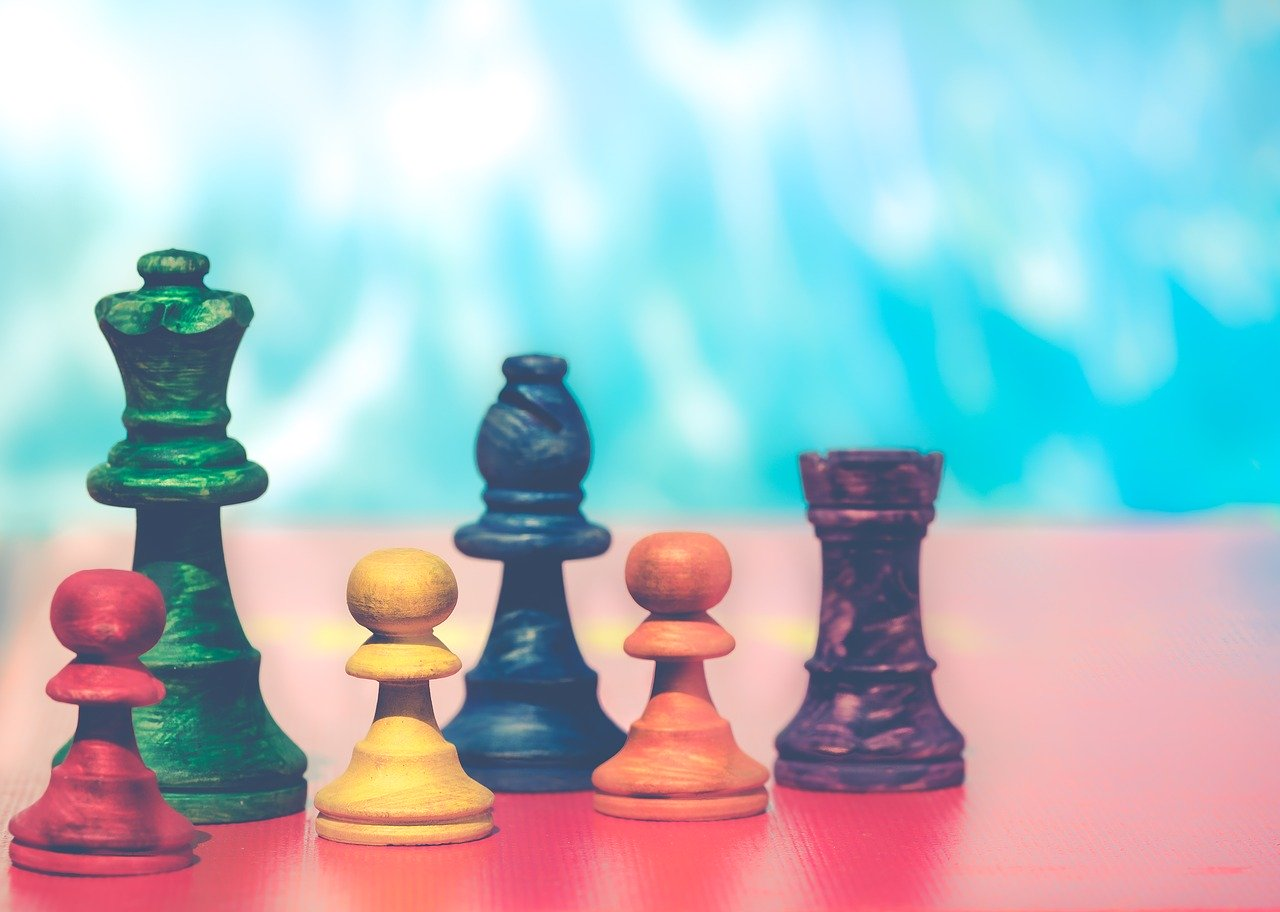

To build a COP (Constraint Optimization Problem) model, we need first to import the library PyCSP$^3$:

In [1]:
from pycsp3 import *

Then, we need some data. Actually, we just need two integers $n$ and $m$.

In [2]:
n = 3  # number of rows
m = 4  # number of columns

We start our COP model by introducing a two-dimensional array $x$ of variables. After a very rough analysis, we can decide to use $n \times m$ as an upper bound of the number of used colors. 

In [3]:
# x[i][j] is the color at row i and column j
x = VarArray(size=[n, m], dom=range(n * m))

We can display the structure of the array, as well as the domain of the first variable (remember that all variables have the same domain).

In [4]:
print("Array x: ", x)
print("Domain of any variable: ", x[0][0].dom)

Array x:  [
  [x[0][0], x[0][1], x[0][2], x[0][3]]
  [x[1][0], x[1][1], x[1][2], x[1][3]]
  [x[2][0], x[2][1], x[2][2], x[2][3]]
]
Domain of any variable:  0..11


Concerning the constraints, we have to impose that at least two corners of any intern rectangle have different colors; the four corners are identified by the coordinates $(i_1,j_1)$, $(i_1,j_2)$, $(i_2,j_1)$ and $(i_2,j_2)$. We use a special case of the constraint *NValues*, seometimes referred to as NotAllEqual: we want that the number of different values taken by some variables (the scope of the constraint) is strictly greater than 1. 

In [5]:
satisfy(
   # at least 2 corners of different colors for any rectangle inside the board
   NValues(x[i1][j1], x[i1][j2], x[i2][j1], x[i2][j2]) > 1
      for i1, i2 in combinations(range(n), 2) for j1, j2 in combinations(range(m), 2) 
);

We can display the internal representation of the posted constraints; this way, although a little bit technical, we can see that all possible rectangles are considered (note that 'gt' stands for '(strictly) greater than').

In [6]:
print(posted())

nValues(list:[x[0][0], x[0][1], x[1][0], x[1][1]], condition:(gt,1))
nValues(list:[x[0][0], x[0][2], x[1][0], x[1][2]], condition:(gt,1))
nValues(list:[x[0][0], x[0][3], x[1][0], x[1][3]], condition:(gt,1))
nValues(list:[x[0][1], x[0][2], x[1][1], x[1][2]], condition:(gt,1))
nValues(list:[x[0][1], x[0][3], x[1][1], x[1][3]], condition:(gt,1))
nValues(list:[x[0][2], x[0][3], x[1][2], x[1][3]], condition:(gt,1))
nValues(list:[x[0][0], x[0][1], x[2][0], x[2][1]], condition:(gt,1))
nValues(list:[x[0][0], x[0][2], x[2][0], x[2][2]], condition:(gt,1))
nValues(list:[x[0][0], x[0][3], x[2][0], x[2][3]], condition:(gt,1))
nValues(list:[x[0][1], x[0][2], x[2][1], x[2][2]], condition:(gt,1))
nValues(list:[x[0][1], x[0][3], x[2][1], x[2][3]], condition:(gt,1))
nValues(list:[x[0][2], x[0][3], x[2][2], x[2][3]], condition:(gt,1))
nValues(list:[x[1][0], x[1][1], x[2][0], x[2][1]], condition:(gt,1))
nValues(list:[x[1][0], x[1][2], x[2][0], x[2][2]], condition:(gt,1))
nValues(list:[x[1][0], x[1][3], x[

Interestingly, by calling the function *solve()*, we can check that the problem is satisfiable (SAT. We can also display the found solution. Here, we call the function *values()* that collects the values assigned to a specified list of variables.

In [7]:
if solve() is SAT:
    print(values(x))

[
  [0, 0, 0, 0]
  [0, 1, 1, 1]
  [0, 1, 2, 2]
]


We obtain a solution, but we do not know if it is optimal. One way of minimizing the number of used colors is to minimize the maximal value taken by variables in $x$.

In [8]:
minimize(
   # minimizing the greatest used color index (and so, the number of colors)
   Maximum(x)
);

We can run again the solver, with this optimization task. Note that we need to check that the status returned by the solver is now OPTIMUM. 

In [9]:
if solve() is OPTIMUM:
    print(values(x))
    print("Optimal number of colors: " , (bound() + 1))

[
  [0, 0, 0, 1]
  [0, 1, 1, 1]
  [1, 1, 0, 0]
]
Optimal number of colors:  2


As a matter of fact, this problem has many symmetries.
It is known that we can break variable symmetries by posting a lexicographic constraint between any two successive rows and any two successive columns. The reader is invited to reflect about the proof.
For posting lexicographic constraints, we use the constraint *LexIncreasing*, with the named parameter *matrix* set to True since the constraint must be applied on each row and each column of the specified two-dimensional array. On the other hand, it is relevant to tag this constraint because it clearly informs us that it is inserted for breaking symmetries (and tags can be exploited by solvers): tagging is made possible by putting in a comment line an expression of the form *tag()*, with a token (or a sequence of tokens separated by a white-space) between parentheses. We write:

In [10]:
satisfy(
   # Increasingly ordering both rows and columns  tag(symmetry-breaking)
   LexIncreasing(x, matrix=True)
);

We can run again the solver.

In [11]:
if solve() is OPTIMUM:
    print(values(x))
    print("Optimal number of colors: " , (bound()+1))

[
  [0, 0, 0, 1]
  [0, 1, 1, 1]
  [1, 0, 1, 0]
]
Optimal number of colors:  2


Importantly, This time, one can observe that all rows and all columns are lexicographically strictly ordered.

Finally, we give below the model in one piece. Here the data is expected to be given by the user (in a command line).